# Optimizing Revenue and Driver Retention in the Taxi Industry: A Data-Driven Analysis of Payment Methods, Fare Pricing, and Revenue Forecasting

## Introduction  
In the highly competitive rental taxi sector, optimizing revenue and ensuring driver satisfaction are crucial for sustained growth and long-term success. With the increasing reliance on data-driven decision-making, understanding the factors influencing fare pricing and revenue generation has become essential. This research aims to uncover actionable insights by analyzing the impact of different payment methods on fare amounts, and developing predictive models to estimate fare prices and driver tips.

## Objective   
By leveraging data-driven insights and predictive analytics, this research seeks to provide a comprehensive understanding of revenue dynamics in the taxi industry. The findings will guide strategic decisions to maximize profits, improve driver satisfaction, and ensure a competitive edge in the rapidly evolving market.
- **Payment Methods and Fare Pricing:** Analyze if different payment methods (e.g., cash, credit/debit card) affect fare amounts. This includes conducting a A/B testing, using python hypothesis testing and descriptive statistics to extract useful information to generate more cash for drivers. In particular, to validate any observed differences in fare pricing of card versus cash payment.

- **Predictive Modeling:** Develop models to predict fare prices and driver tips, aiding in profit estimation and driver retention. Additionaly, suggest tip amount to customers by predicting tips based on trip distance and duration.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import warnings

In [2]:
warnings.filterwarnings('ignore')

### Loading dataset

In [3]:
data = pd.read_csv('/kaggle/input/newyork-yellow-taxi-trip-data-2020-2019/yellow_tripdata_2020-01.csv')
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.2,1.0,N,238,239,1.0,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5
1,1.0,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.2,1.0,N,239,238,1.0,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5
2,1.0,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.6,1.0,N,238,238,1.0,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5
3,1.0,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.8,1.0,N,238,151,1.0,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0
4,2.0,2020-01-01 00:01:58,2020-01-01 00:04:16,1.0,0.0,1.0,N,193,193,2.0,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0.0


### Column Descriptions

| Column                  | Description                                                                                   | Values                                                                                                 |
|-------------------------|-----------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------|
| **VendorID**            | Identifier for the TPEP provider supplying the record.                                        | 1 = Creative Mobile Technologies, LLC<br>2 = VeriFone Inc.                                             |
| **tpep_pickup_datetime**| The date and time when the meter was activated.                                               | -                                                                                                      |
| **tpep_dropoff_datetime**| The date and time when the meter was turned off.                                              | -                                                                                                      |
| **Passenger_count**     | The number of passengers in the vehicle, as entered by the driver.                            | -                                                                                                      |
| **Trip_distance**       | The distance of the trip in miles, as recorded by the taximeter.                              | -                                                                                                      |
| **PULocationID**        | TLC Taxi Zone where the meter was engaged.                                                    | -                                                                                                      |
| **DOLocationID**        | TLC Taxi Zone where the meter was disengaged.                                                 | -                                                                                                      |
| **RateCodeID**          | The applicable rate code at the end of the trip.                                              | 1 = Standard rate<br>2 = JFK<br>3 = Newark<br>4 = Nassau or Westchester<br>5 = Negotiated fare<br>6 = Group ride |
| **Store_and_fwd_flag**  | Indicates if the trip record was stored in the vehicle's memory before transmission to the vendor due to lack of server connection. | Y = Store and forward trip<br>N = Not a store and forward trip                                         |
| **Payment_type**        | How the passenger paid for the trip, represented by a numeric code.                           | 1 = Credit card<br>2 = Cash<br>3 = No charge<br>4 = Dispute<br>5 = Unknown<br>6 = Voided trip          |
| **Fare_amount**         | The fare as calculated by the meter based on time and distance.                               | -                                                                                                      |
| **Extra**               | Additional charges, currently including only the $0.50 and $1 rush hour and overnight charges.| -                                                                                                      |
| **MTA_tax**             | A $0.50 tax automatically added based on the metered rate.                                    | -                                                                                                      |
| **Improvement_surcharge**| A $0.30 surcharge added at the start of the trip, implemented since 2015.                     | -                                                                                                      |
| **Tip_amount**          | Credit card tip amounts. (Note: Cash tips are not recorded here.)                             | -                                                                                                      |
| **Tolls_amount**        | Total tolls paid during the trip.                                                             | -                                                                                                      |
| **Total_amount**        | The total charge to passengers, excluding cash tips.                                          | -                                                                                                      |


# Exploratory Data Analysis

In [4]:
data.shape

(6405008, 18)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6405008 entries, 0 to 6405007
Data columns (total 18 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               float64
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        float64
 4   trip_distance          float64
 5   RatecodeID             float64
 6   store_and_fwd_flag     object 
 7   PULocationID           int64  
 8   DOLocationID           int64  
 9   payment_type           float64
 10  fare_amount            float64
 11  extra                  float64
 12  mta_tax                float64
 13  tip_amount             float64
 14  tolls_amount           float64
 15  improvement_surcharge  float64
 16  total_amount           float64
 17  congestion_surcharge   float64
dtypes: float64(13), int64(2), object(3)
memory usage: 879.6+ MB


In [6]:
data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])

In [7]:
data['trip_timings'] = data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']
data['trip_duration'] = data['trip_timings'].dt.total_seconds()/60

In [8]:
data.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'trip_timings',
       'trip_duration'],
      dtype='object')

## **Payment Methods and Fare Pricing:**
- Since our objective revolves around payment type, fare amount and any other factor influencing the fare amount ,we are filtering only the required columns for statistical analysis. 

In [9]:
df = data[['passenger_count', 'trip_distance','payment_type','fare_amount','trip_duration']]
df.head()

,passenger_count,trip_distance,payment_type,fare_amount,trip_duration
0,1.0,1.2,1.0,6.0,4.800000
1,1.0,1.2,1.0,7.0,7.416667
2,1.0,0.6,1.0,6.0,6.183333
3,1.0,0.8,1.0,5.5,4.850000
4,1.0,0.0,2.0,3.5,2.300000


In [10]:
df.shape

(6405008, 5)

In [11]:
#checking for missing values
df.isnull().sum()

passenger_count    65441
trip_distance          0
payment_type       65441
fare_amount            0
trip_duration          0
dtype: int64

In [12]:
print('Missing data %:')
round(df.isnull().sum()*100/df.shape[0],2)

Missing data %:


passenger_count    1.02
trip_distance      0.00
payment_type       1.02
fare_amount        0.00
trip_duration      0.00
dtype: float64

#### Since only 1% data is missing we will drop the null values

In [13]:
df.dropna(inplace=True)
df.shape

(6339567, 5)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6339567 entries, 0 to 6339566
Data columns (total 5 columns):
 #   Column           Dtype  
---  ------           -----  
 0   passenger_count  float64
 1   trip_distance    float64
 2   payment_type     float64
 3   fare_amount      float64
 4   trip_duration    float64
dtypes: float64(5)
memory usage: 290.2 MB


In [15]:
df['passenger_count'] = df['passenger_count'].astype('int64')
df['payment_type'] = df['payment_type'].astype('int64')

In [16]:
#checking for duplicate values
df[df.duplicated()==True]

,passenger_count,trip_distance,payment_type,fare_amount,trip_duration
2056,1,0.00,2,7.0,0.000000
2441,1,0.00,1,52.0,0.200000
2446,2,1.70,1,9.5,13.066667
2465,1,0.40,1,4.0,3.083333
3344,1,1.20,1,6.0,5.350000
...,...,...,...,...,...
6339558,1,1.63,2,8.0,8.800000
6339559,1,1.81,1,8.5,8.016667
6339560,1,0.98,2,6.5,6.900000
6339562,1,2.10,1,11.0,14.233333


In [17]:
# dropping duplicate values as they won't contribute in analysis
df.drop_duplicates(inplace=True)
df.shape

(3007861, 5)

In [18]:
# passenger count distribution
df['passenger_count'].value_counts()

passenger_count
1    1750518
2     572547
3     199602
5     189305
6     118124
4     108422
0      69280
7         28
9         18
8         17
Name: count, dtype: int64

In [19]:
# dropping zero passenger count as no passenger means no one paid the fare amount
df = df[(df['passenger_count']!=0) & (df['passenger_count']<7)]
df['passenger_count'].value_counts()

passenger_count
1    1750518
2     572547
3     199602
5     189305
6     118124
4     108422
Name: count, dtype: int64

In [20]:
# payment type distribution
df['payment_type'].value_counts()

payment_type
1    1993335
2     904823
3      24591
4      15768
5          1
Name: count, dtype: int64

#### As our analysis centers around card and cash payment we are keeping only card and cash payment denoted by 1 and 2 respectively 

In [21]:
df = df[df['payment_type']<3]
df['payment_type'].value_counts()

payment_type
1    1993335
2     904823
Name: count, dtype: int64

In [22]:
# Final remaining data
df.shape

(2898158, 5)

In [23]:
# Changing the encoded values of payment type to actual labels
df['payment_type'].replace([1,2],['Card','Cash'],inplace=True)

In [24]:
# Descriptive statistics
df.describe()

,passenger_count,trip_distance,fare_amount,trip_duration
count,2.898158e+06,2.898158e+06,2.898158e+06,2.898158e+06
mean,1.906919e+00,4.479349e+00,1.761232e+01,2.402879e+01
std,1.427756e+00,4.867743e+00,1.495772e+01,9.293099e+01
min,1.000000e+00,-2.218000e+01,-5.000000e+02,-2.770367e+03
25%,1.000000e+00,1.470000e+00,8.500000e+00,9.716667e+00
50%,1.000000e+00,2.690000e+00,1.300000e+01,1.553333e+01
75%,2.000000e+00,5.370000e+00,2.100000e+01,2.318333e+01
max,6.000000e+00,2.628800e+02,4.265000e+03,8.525117e+03


#### Trip distance, fare amount, trip duration cannot be negative. Need to remove the wrong values. Also there are lot of outliers present in these values as there is a huge gap between 75 percentile and max value. 

In [25]:
# removing negative values
df = df[df['trip_distance']>0]
df = df[df['fare_amount']>0]
df = df[df['trip_duration']>0]
df.shape

(2866585, 5)

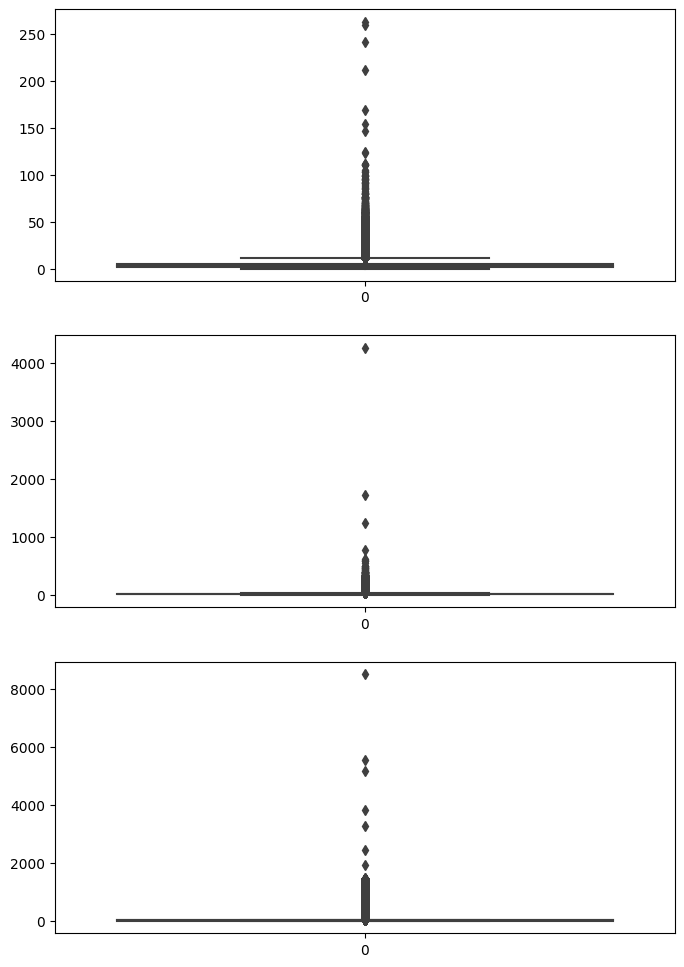

In [26]:
# checking outliers
plt.figure(figsize = (8,12))
plt.subplot(3,1,1)
sns.boxplot(df['trip_distance'])
plt.subplot(3,1,2)
sns.boxplot(df['fare_amount'])
plt.subplot(3,1,3)
sns.boxplot(df['trip_duration'])
plt.show()

In [27]:
# removing outliers using IQR method
def outlier_r(df,col):
    q1 = df[col].quantile(0.25)
    q2 = df[col].quantile(0.75)
    IQR = q2-q1
    lower_bound = q1-1.5*IQR
    upper_bound = q2+1.5*IQR
    df = df[(df[col]>=lower_bound) & (df[col]<=upper_bound)]
    return df

for col in ['trip_distance','fare_amount','trip_duration']:
    df = outlier_r(df,col)
    
df.shape

(2468583, 5)

In [28]:
df.describe()

,passenger_count,trip_distance,fare_amount,trip_duration
count,2.468583e+06,2.468583e+06,2.468583e+06,2.468583e+06
mean,1.965640e+00,3.006961e+00,1.297947e+01,1.475669e+01
std,1.463491e+00,2.223115e+00,6.281237e+00,7.404872e+00
min,1.000000e+00,1.000000e-02,1.000000e-02,1.666667e-02
25%,1.000000e+00,1.380000e+00,8.000000e+00,9.033333e+00
50%,1.000000e+00,2.350000e+00,1.150000e+01,1.401667e+01
75%,2.000000e+00,3.970000e+00,1.650000e+01,1.970000e+01
max,6.000000e+00,1.127000e+01,3.100000e+01,3.635000e+01


#### The objective is to explore relationship between payment type and the concerning trip distance and fare amount.  
#### Are there variations in the payment type concerning different fare amounts or trip distance?  

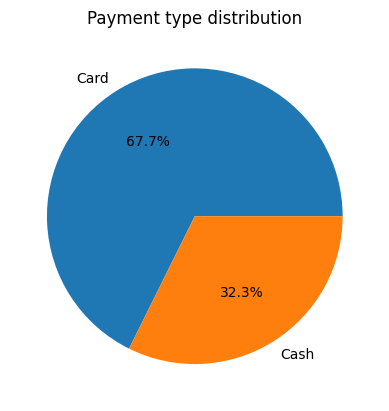

In [29]:
plt.title('Payment type distribution')
plt.pie(df['payment_type'].value_counts(normalize=True),labels=df['payment_type'].value_counts(normalize=True).index,
       autopct='%1.1f%%')
plt.show()

#### Card payment is more, clocking at 67.7%

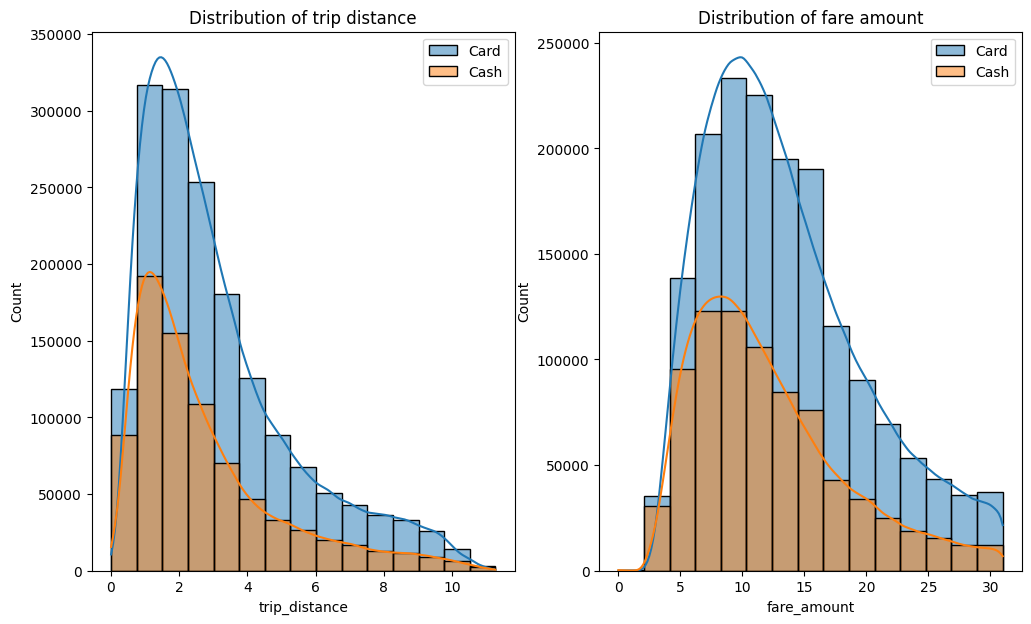

In [30]:
plt.figure(figsize=(12,7))
plt.subplot(1,2,1)
plt.title('Distribution of trip distance')
sns.histplot(df[df['payment_type']=='Card']['trip_distance'],bins = 15,kde=True,label='Card')
sns.histplot(df[df['payment_type']=='Cash']['trip_distance'],bins = 15,kde=True,label='Cash')
plt.legend()
plt.subplot(1,2,2)
plt.title('Distribution of fare amount')
sns.histplot(df[df['payment_type']=='Card']['fare_amount'],bins = 15,kde=True,label='Card')
sns.histplot(df[df['payment_type']=='Cash']['fare_amount'],bins = 15,kde=True,label='Cash')
plt.legend()
plt.show()

In [31]:
df.groupby(['payment_type']).agg({'trip_distance':['mean','std'],'fare_amount':['mean','std']})

trip_distance           fare_amount         
                      mean       std        mean      std
payment_type                                             
Card              3.134509  2.239577   13.417504  6.32437
Cash              2.740085  2.164087   12.062938  6.08891

#### The mean for card is more than cash in both trip distance and fare amount. This indicates that passengers are more inclined to pay with card.  
#### On any trip distance card is the preffered mode, however when the fare amount is on lower scale there is less difference between the preferences.  
#### But as distance and fare amount increase, the preference to pay with card increases.

#### Subsequently, the objective now is to analysis the payment types in relation to the passenger count.  
#### Our objective is to check whether there are any changes in payment preference related to the number of passengers travelling in the cab.

In [32]:
# checking the payment type distribution in percentage based on passenger count
payment=df.groupby(['payment_type','passenger_count'])[['passenger_count']].count()
payment.rename(columns = {'passenger_count':'count'},inplace = True)
payment.reset_index(inplace=True)
payment['percentage'] = payment['count']*100/payment['count'].sum()
payment

,payment_type,passenger_count,count,percentage
0,Card,1,942820,38.192761
1,Card,2,334447,13.548137
2,Card,3,124098,5.027094
3,Card,4,64507,2.613119
4,Card,5,125752,5.094096
5,Card,6,78677,3.187132
6,Cash,1,473215,19.169499
7,Cash,2,158432,6.417933
8,Cash,3,55305,2.240354
9,Cash,4,33098,1.340769


In [33]:
# rearranging the data for horizontal stacked bar chart
payment_dist = pd.DataFrame(columns=['payment_type',1,2,3,4,5,6])
payment_dist['payment_type']=['Card','Cash']
payment_dist.iloc[0,1:]=payment.iloc[:6,3]
payment_dist.iloc[1,1:]=payment.iloc[6:,3]
payment_dist

,payment_type,1,2,3,4,5,6
0,Card,38.192761,13.548137,5.027094,2.613119,5.094096,3.187132
1,Cash,19.169499,6.417933,2.240354,1.340769,1.956183,1.212923


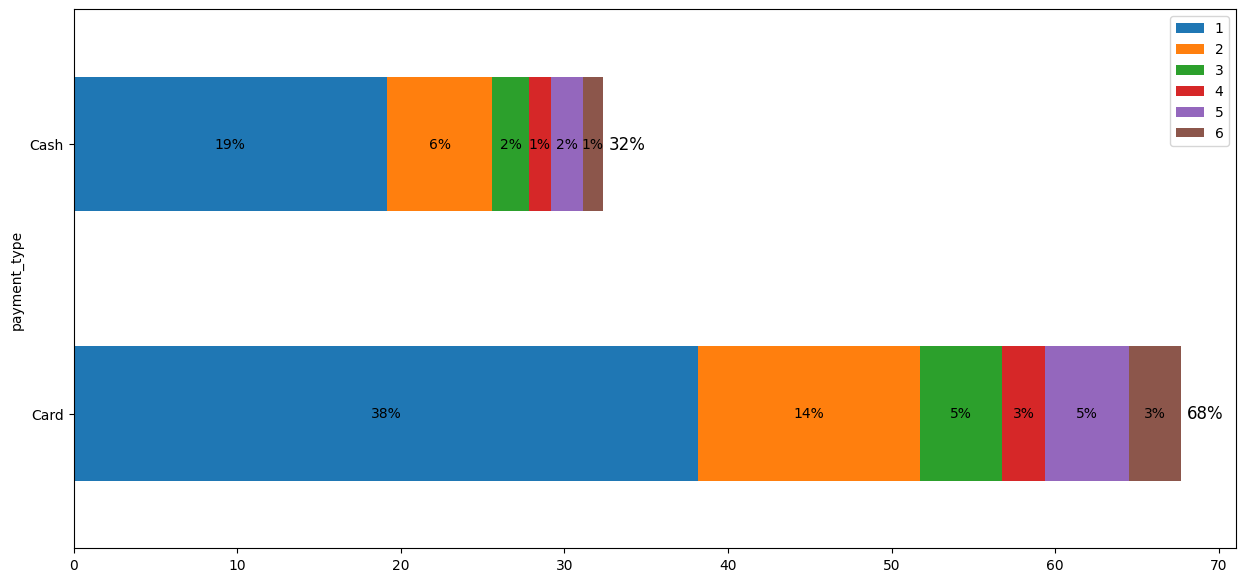

In [34]:
# plotting the horizontal bar chart
fig,ax = plt.subplots(figsize=(15,7))
payment_dist.plot(x='payment_type',kind='barh',stacked=True,ax=ax)

for i in ax.patches:
    w = i.get_width()
    h = i.get_height()
    x,y = i.get_xy()
    ax.text(x+w/2,y+h/2,'{:.0f}%'.format(w),ha='center',va='center')
    
totals = payment_dist.iloc[:,1:].sum(axis=1)
for i, total in enumerate(totals):
    y=i
    ax.text(total+1.5, y,'{:.0f}%'.format(total), ha='center', va = 'center', fontsize = 12)

- Passenger count of 1 constitutes maximum of the payments in both cash and card payment followed by passenger count of 2.
- The plot also says that card payment is preffered in any number of passenger counts.

## **Hypothesis testing**
- First we will check whether the distribution of fare amount adheres to the normal ditribution. Even though the histogram above depicts otherwise, we will use Quantile-Quantile (QQ) plot for further confirmation.

In [35]:
import statsmodels.api as sm

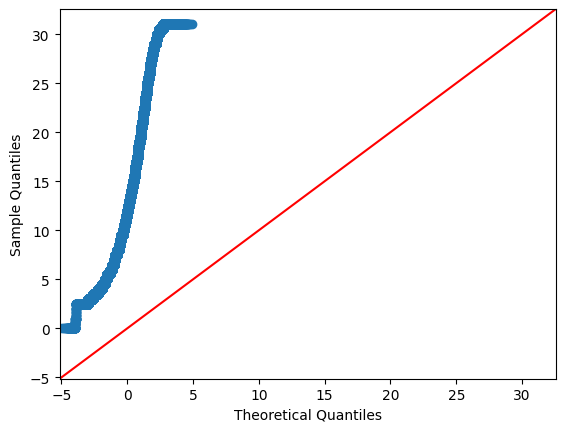

In [36]:
sm.qqplot(df['fare_amount'], line = '45')
plt.show()

- The data plots do not align (not even closely) to the diagonal line, suggesting it doesn't follow a normal distribution.  
- So instead of z-test we will use a t-test for our hypothesis testing. Moreover the population variance is also not known suggesting that a t-test will be a better estimate as it can accomodate the uncertainities that come with estimating population parameters from sample data.  
  
#### *Null hypothesis*: There is no difference in average fare between customers who use credit card and customers who use cash.  
#### *Alternate hypothesis*: There is a difference in average fare between customers who use credit and customers who use cash.

In [37]:
# sample 1
card_sample = df[df['payment_type']=="Card"]['fare_amount']
# sample 2
cash_sample = df[df['payment_type']=="Cash"]['fare_amount']

Performing an F-test to check the relation between variances of the sample

In [38]:
# F-test
def F_test(data1,data2, alpha = 0.05):
    var1 = np.var(data1,ddof=1)
    var2 = np.var(data2,ddof=1)
    len1 = len(data1)-1
    len2 = len(data2)-1
    if var1 > var2:
        F = var1/var2
    else:
        F = var2/var1
    p = 1-st.f.cdf(F,len1,len2)
    if p < alpha:
        print('Variances are not same')
    else: 
        print('Variances are same')
        
        
F_test(card_sample,cash_sample)

Variances are not same


Performing a two sample t-test to check our hypothesis

In [39]:
# two sample t-test
t_stats, p_value = st.ttest_ind(a=card_sample,b=cash_sample,equal_var=False) # variances are not equal
if p_value < 0.05:
    print(f'p_value = {p_value}, Reject null hypothesis')
else:
    print(f'p_value = {p_value},Accept null hypothesis')

p_value = 0.0, Reject null hypothesis


#### Since the p-values is less than the significance level of 5%, the null hypothesis is rejected.  
#### There is a statistically significant difference in average fare amount between passengers who pay with cash and passengers who use card.  
### *The bussiness can generate more revenue by encouraging customers to pay with card and should market offers or advertisements accordingly*

## **Predictive Modeling**  
- The objective here will be to use machine learning models, specially regression, to predict the fare amount based on trip distance and trip duration. This will further help the buiseness in planing and allocating resources accordingly.  
- Additionally the models will also be used to predict tip amounts based on trip distance and trip duration. This will help the business to retrain as well as increase their driver base by suggesting tip amounts to passengers.  
  
*Regression* - Linear Regression  

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as le
from sklearn import metrics
from sklearn.model_selection import cross_validate

### Prediction of fare amount based on trip distance and trip duration
- The objective here is to create a regression model for predicting fare amount based on trip distance and trip duration. The required columns are filtered accordingly.

In [41]:
ML_data = data[['trip_distance','trip_duration','fare_amount']]
ML_data.head()

,trip_distance,trip_duration,fare_amount
0,1.2,4.800000,6.0
1,1.2,7.416667,7.0
2,0.6,6.183333,6.0
3,0.8,4.850000,5.5
4,0.0,2.300000,3.5


In [42]:
ML_data.shape

(6405008, 3)

In [43]:
ML_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6405008 entries, 0 to 6405007
Data columns (total 3 columns):
 #   Column         Dtype  
---  ------         -----  
 0   trip_distance  float64
 1   trip_duration  float64
 2   fare_amount    float64
dtypes: float64(3)
memory usage: 146.6 MB


In [44]:
ML_data.isnull().sum()

trip_distance    0
trip_duration    0
fare_amount      0
dtype: int64

In [45]:
ML_data.describe()

,trip_distance,trip_duration,fare_amount
count,6.405008e+06,6.405008e+06,6.405008e+06
mean,2.929644e+00,1.595008e+01,1.269411e+01
std,8.315911e+01,6.322999e+01,1.212730e+01
min,-3.062000e+01,-2.770367e+03,-1.238000e+03
25%,9.600000e-01,6.366667e+00,6.500000e+00
50%,1.600000e+00,1.048333e+01,9.000000e+00
75%,2.930000e+00,1.683333e+01,1.400000e+01
max,2.102401e+05,8.525117e+03,4.265000e+03


The negative values need to be removed. Also outliers are present and needs to be removed.

In [46]:
# removing negative values
ML_data = ML_data[ML_data['trip_distance']>0]
ML_data = ML_data[ML_data['trip_duration']>0]
ML_data = ML_data[ML_data['fare_amount']>0]

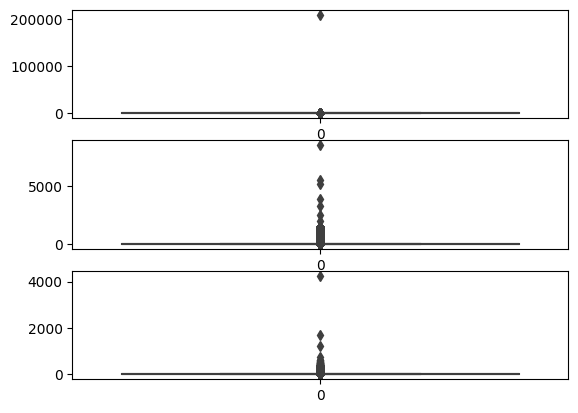

In [47]:
# outlier detection
plt.subplot(3,1,1)
sns.boxplot(ML_data['trip_distance'])
plt.subplot(3,1,2)
sns.boxplot(ML_data['trip_duration'])
plt.subplot(3,1,3)
sns.boxplot(ML_data['fare_amount'])
plt.show()

In [48]:
# outliers removal through IQR method
for col in ['trip_distance','fare_amount','trip_duration']:
    ML_data = outlier_r(ML_data,col)
    
ML_data.shape

(5351996, 3)

In [49]:
# check for duplicates
ML_data[ML_data.duplicated()]

,trip_distance,trip_duration,fare_amount
1032,1.11,5.700000,6.00
1052,0.60,5.750000,5.50
1075,0.80,4.016667,5.00
1202,1.50,9.533333,8.00
1409,3.00,12.683333,12.00
...,...,...,...
6404233,1.68,9.566667,8.00
6404271,3.45,14.000000,17.44
6404419,1.43,11.000000,16.23
6404819,0.79,6.000000,16.08


In [50]:
# dropping the duplicates
ML_data.drop_duplicates(keep='first',inplace = True)
ML_data.shape

(982756, 3)

Creating the feature variables asnd target variable

In [51]:
x = ML_data[['trip_distance','trip_duration']]
y = ML_data['fare_amount']

In [52]:
# spliting the data into train and test set
train_x,test_x,train_y,test_y = train_test_split(x,y,test_size=0.2)

In [53]:
# creating the model and cross validating
fare_model = le()
cross_validate(fare_model,train_x,train_y,cv=5,scoring=['neg_root_mean_squared_error'])

{'fit_time': array([0.13758564, 0.1426909 , 0.16622758, 0.14233804, 0.13897181]),
 'score_time': array([0.0061872 , 0.00483179, 0.01406789, 0.00542569, 0.0046072 ]),
 'test_neg_root_mean_squared_error': array([-0.92190133, -0.90890115, -0.91398317, -0.92515009, -0.91029444])}

The RMSE seems to be considerable in the data.We can move forward with training the linear model.

In [54]:
# fitting the model
fare_model.fit(train_x,train_y)

# predicting with the model
pred_fare = fare_model.predict(test_x)

#checking the mean squared error for the model
print('Mean square error of predicted values -->',metrics.mean_squared_error(test_y,pred_fare))

Mean square error of predicted values --> 0.8313971426828081


In [55]:
print('Coefficient of model -->',fare_model.coef_)
print('Bias of model -->',fare_model.intercept_)

Coefficient of model --> [1.70156921 0.36791054]
Bias of model --> 2.3713891527319024


We now implement boosting techniques to check if we can enhances the model performances  
The boosting technique used here is Gradient boosting. The initial predicion of the model is used to calculate the difference between the actual and predicted values, after that the difference values is taken as an input to a decision tree classifier to give better predictions. Thus process continues until a desired result is obtained.

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

The hyperparameter tunning for the model is performed now

In [57]:
params = {
    'n_estimators' : [300, 600, 1000],
    }
fare_gradboost_model = GradientBoostingRegressor(init = fare_model, random_state = 42, learning_rate = 0.01)
grid_fare = GridSearchCV(estimator = fare_gradboost_model, param_grid = params, scoring = 'neg_mean_squared_error', cv = 4,verbose = 3, refit = True)
grid_fare.fit(train_x,train_y)

Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV 1/4] END .................n_estimators=300;, score=-0.768 total time= 2.2min
[CV 2/4] END .................n_estimators=300;, score=-0.750 total time= 2.2min
[CV 3/4] END .................n_estimators=300;, score=-0.770 total time= 2.2min
[CV 4/4] END .................n_estimators=300;, score=-0.757 total time= 2.2min
[CV 1/4] END .................n_estimators=600;, score=-0.747 total time= 4.4min
[CV 2/4] END .................n_estimators=600;, score=-0.730 total time= 4.4min
[CV 3/4] END .................n_estimators=600;, score=-0.748 total time= 4.4min
[CV 4/4] END .................n_estimators=600;, score=-0.735 total time= 4.3min
[CV 1/4] END ................n_estimators=1000;, score=-0.731 total time= 7.3min
[CV 2/4] END ................n_estimators=1000;, score=-0.720 total time= 7.3min
[CV 3/4] END ................n_estimators=1000;, score=-0.733 total time= 7.2min
[CV 4/4] END ................n_estimators=1000;, 

GridSearchCV(cv=4,
             estimator=GradientBoostingRegressor(init=LinearRegression(),
                                                 learning_rate=0.01,
                                                 random_state=42),
             param_grid={'n_estimators': [300, 600, 1000]},
             scoring='neg_mean_squared_error', verbose=3)

In [58]:
print('Best hyperparameter for the model -->',grid_fare.best_params_)

Best hyperparameter for the model --> {'n_estimators': 1000}


In [59]:
# predicting with the model 
pred_fare_boosted = grid_fare.predict(test_x)

#checking the mean squared error for the model
print('Mean square error of predicted values -->',metrics.mean_squared_error(test_y,pred_fare_boosted))

Mean square error of predicted values --> 0.7135693934566413


#### The RMSE value has reduced after gradient boosting the linear model

Creating some random scenario to predict fare amount

In [60]:
# for a trip distance of 4 and trip duration of 15
input_value = np.array([4,15]).reshape(1,2)
fare = round(float(grid_fare.predict(input_value)),2)
print(f'The predicted fare is -->{fare}')

The predicted fare is -->14.64


### Prediction of tip amount based on trip distance and trip duration
- The objective here is to create a regression model for predicting tip amount based on trip distance and trip duration. The required columns are filtered accordingly.

In [61]:
tips_data = data[['trip_distance','trip_duration','tip_amount']]
tips_data.head()

,trip_distance,trip_duration,tip_amount
0,1.2,4.800000,1.47
1,1.2,7.416667,1.50
2,0.6,6.183333,1.00
3,0.8,4.850000,1.36
4,0.0,2.300000,0.00


In [62]:
tips_data.shape

(6405008, 3)

In [63]:
tips_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6405008 entries, 0 to 6405007
Data columns (total 3 columns):
 #   Column         Dtype  
---  ------         -----  
 0   trip_distance  float64
 1   trip_duration  float64
 2   tip_amount     float64
dtypes: float64(3)
memory usage: 146.6 MB


In [64]:
tips_data.isnull().sum()

trip_distance    0
trip_duration    0
tip_amount       0
dtype: int64

In [65]:
# dropping duplicates
tips_data.drop_duplicates(inplace=True)
tips_data.shape

(3328952, 3)

In [66]:
tips_data.describe()

,trip_distance,trip_duration,tip_amount
count,3.328952e+06,3.328952e+06,3.328952e+06
mean,4.303244e+00,2.249341e+01,3.036435e+00
std,1.153256e+02,8.685545e+01,3.403018e+00
min,-3.062000e+01,-2.770367e+03,-9.100000e+01
25%,1.370000e+00,9.000000e+00,1.080000e+00
50%,2.460000e+00,1.466667e+01,2.450000e+00
75%,4.960000e+00,2.226667e+01,3.840000e+00
max,2.102401e+05,8.525117e+03,1.100000e+03


In [67]:
# removing negative values
tips_data = tips_data[tips_data['tip_amount']>0]
tips_data = tips_data[tips_data['trip_distance']>0]
tips_data = tips_data[tips_data['trip_duration']>0]

# outliers removal through IQR method
for col in ['trip_distance','tip_amount','trip_duration']:
    tips_data = outlier_r(tips_data,col)
    
tips_data.shape

(2296282, 3)

In [68]:
tips_data.describe()

,trip_distance,trip_duration,tip_amount
count,2.296282e+06,2.296282e+06,2.296282e+06
mean,2.402212e+00,1.309606e+01,2.705756e+00
std,1.668954e+00,6.747438e+00,1.247450e+00
min,1.000000e-02,1.666667e-02,1.000000e-02
25%,1.190000e+00,7.816667e+00,1.780000e+00
50%,1.950000e+00,1.230000e+01,2.560000e+00
75%,3.130000e+00,1.755000e+01,3.460000e+00
max,8.850000e+00,3.276667e+01,6.360000e+00


#### The average tip appears to be around 2.56 and extending till 6.36

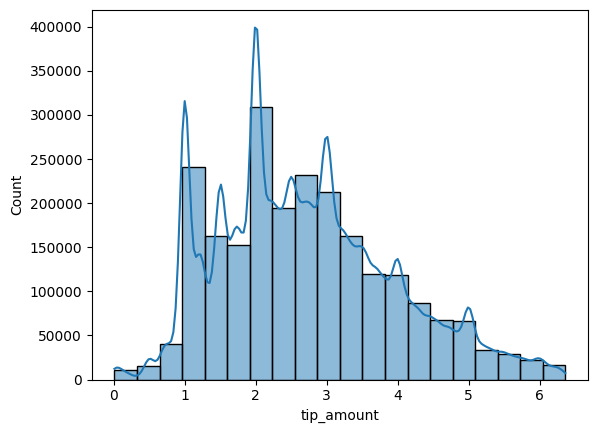

In [69]:
sns.histplot(x = tips_data['tip_amount'], bins = 20, kde = True)
plt.show()

#### The distribution doesn't seems to be normaly distributed. There appears to be three peaks with two peaks below the mean value, suggesting that max drivers get paid less than average tip by passenger. Buiseness can put up ads in the form of suggestion to encourage customers to pay more tip so that driver retention and income can increase.

#### Based on the above conclusion we will create a ML model using regression for auto suggesting tip amount based on the current data.


Creating the feature variables asnd target variable

In [70]:
x = tips_data[['trip_distance', 'trip_duration']]
y = tips_data['tip_amount']

# spliting the data into train and test set
train_x,test_x,train_y,test_y = train_test_split(x,y,test_size=0.2)

In [71]:
# creating the model and cross validating
tip_model = le()
cross_validate(tip_model,train_x,train_y,cv=5,scoring=['neg_root_mean_squared_error'])

{'fit_time': array([0.30220604, 0.31185198, 0.30890012, 0.30973458, 0.31025672]),
 'score_time': array([0.02189708, 0.0140059 , 0.01512384, 0.01374173, 0.01538587]),
 'test_neg_root_mean_squared_error': array([-0.93121631, -0.93101795, -0.93399407, -0.93213   , -0.93251911])}

The RMSE seems to be considerable in the data. We can move forward with training the linear model.

In [72]:
# fitting the model
tip_model.fit(train_x,train_y)

# predicting with the model
pred_tip = tip_model.predict(test_x)

#checking the mean squared error for the model
print('Mean square error of predicted values -->',metrics.mean_squared_error(test_y,pred_tip))

Mean square error of predicted values --> 0.8745971088008591


In [73]:
print('Coefficient of model -->',tip_model.coef_)
print('Bias of model -->',tip_model.intercept_)

Coefficient of model --> [0.27373359 0.06569485]
Bias of model --> 1.1884490195959505


Creating some random scenario to predict tip amount

In [74]:
# for a trip distance of 4 and trip duration of 15
input_value = np.array([4,15]).reshape(1,2)
tip = round(float(tip_model.predict(input_value)),2)
print(f'The predicted tip is -->{tip}')

The predicted tip is -->3.27
